<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MyBasicDiffusionModelSimpleFigures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import random

SHAPES = ["triangle", "circle"]
PLURALS = [shape + "s" for shape in SHAPES]
ARTICLES = ["a", "one"]
TWO_ARTICLES = ["two"]
CONNECTORS = ["and", "then"]
REVERSE_CONNECTORS = ["after"]
CLASS_TOKEN = "CLS"
MASK_TOKEN = "MASK"
SEP_TOKEN = "SEP"
PAD_TOKEN = "PAD"
EOS_TOKEN = "EOS"
SPECIAL_TOKENS = [CLASS_TOKEN, MASK_TOKEN, SEP_TOKEN, PAD_TOKEN, EOS_TOKEN]
VOCABULARY = SHAPES + PLURALS + ARTICLES + CONNECTORS + REVERSE_CONNECTORS + TWO_ARTICLES + SPECIAL_TOKENS
MAX_LEN_SENTENCE = 16 # Maximum possible length of a sequence

def generate_random_shapes():
  num_shapes = random.randint(1, 4)
  result = []
  for _ in range(num_shapes):
    result.append(random.choice(SHAPES))
  return result

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def generate_image(word_list, filename, mask_filename):
    # Create a blank 32x32 image
    image_size = 8
    patch_size = 4
    image = Image.new("1", (image_size, image_size), 1)  # '1' for 1-bit pixels, black and white
    mask = Image.new("1", (image_size, image_size), 1)

    for i, word in enumerate(word_list):
        if word not in ["triangle", "circle"]:
            continue

        # Determine the top-left corner of the patch
        x_offset = (i % 2) * patch_size
        y_offset = (i // 2) * patch_size

        # Draw the shape in the corresponding patch
        draw = ImageDraw.Draw(image)
        draw_mask = ImageDraw.Draw(mask)
        if word == "triangle":
            draw.rectangle([x_offset, y_offset, x_offset + patch_size - 1, y_offset + patch_size - 1], fill=0)
        elif word == "circle":
            draw.ellipse([x_offset + 1, y_offset + 1, x_offset + patch_size - 2, y_offset + patch_size - 2], fill=0)

    # Save the image to the specified filename
    image.save(filename)
    mask.save(mask_filename)

def plot_image(filename):
    # Open the image
    image = Image.open(filename)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
generate_image(["circle", "triangle", "circle"], "output_image.png", "masked_output_image.png")

In [29]:
def generate_data(n_samples):
  examples = []
  for i in range(n_samples):
    shape_list = generate_random_shapes()
    filename = f"f{i}.png"
    mask_filename = f"m{i}.png"
    generate_image(shape_list, filename, mask_filename)
    examples.append({"shape_list": shape_list, "filename": filename, "mask_filename": mask_filename})
  return examples

In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [32]:
class FigureDataset(Dataset):
    def __init__(self, n_samples, image_dir, transform, device):
        self.image_dir = image_dir
        self.transform = transform
        self.examples = generate_data(n_samples)
        self.device = device
        self.image_files = [e["filename"] for e in self.examples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')

        image = self.transform(image).to(device)

        return image

In [33]:
import math

class MyPositionalEncoding():
    def __init__(self, d_model, T, device):

        with torch.no_grad():

          # Create a matrix of shape (max_len, d_model) with all zeros
          self.pe = torch.zeros(T + 1, d_model).to(device)

          # Create a column vector of shape (max_len, 1) with values [0, 1, ..., max_len-1]
          position = torch.arange(0, T + 1, dtype=torch.float).unsqueeze(1).to(device)

          # Create a row vector of shape (1, d_model // 2) with values [0, 1, ..., d_model//2-1]
          div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)).to(device)

          # Apply sine to even indices and cosine to odd indices
          self.pe[:, 0::2] = torch.sin(position * div_term).to(device)
          self.pe[:, 1::2] = torch.cos(position * div_term).to(device)

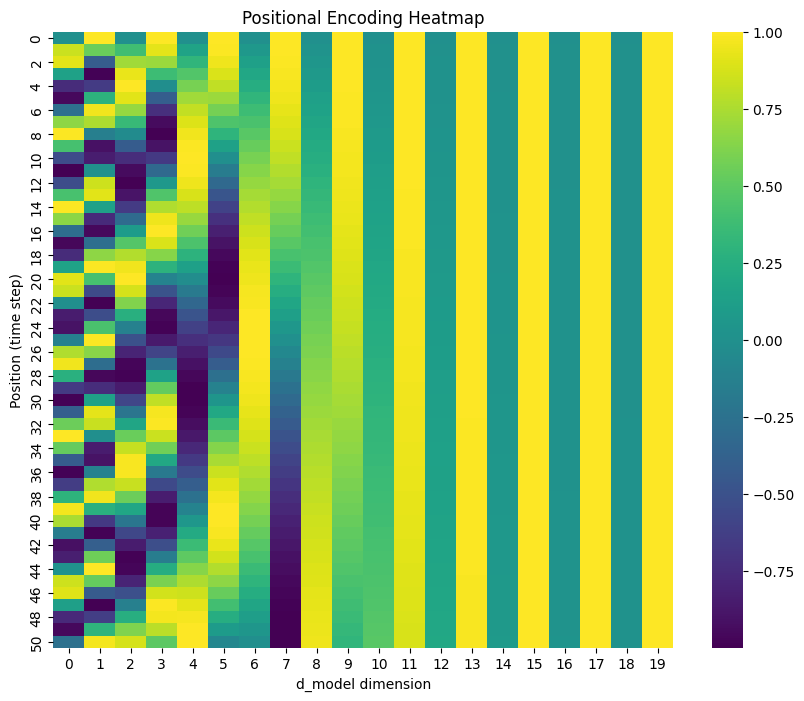

In [34]:
import seaborn as sns

# Instantiate the class with example parameters
d_model = 20  # Dimensionality of the model
T = 50        # Maximum time or sequence length
pos_encoding = MyPositionalEncoding(d_model, T, device)

# Convert the positional encoding tensor to a NumPy array
pe_matrix = pos_encoding.pe.cpu().numpy()

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(pe_matrix, cmap='viridis', cbar=True)
plt.title("Positional Encoding Heatmap")
plt.xlabel("d_model dimension")
plt.ylabel("Position (time step)")
plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DiffusionModel(nn.Module):
    def __init__(self, model, device, T=1000, beta_start=1e-4, beta_end=0.02):
        super(DiffusionModel, self).__init__()
        self.model = model  # This model should predict the noise ε_θ
        self.T = T  # Number of timesteps
        self.device = device
        with torch.no_grad():
          self.betas = torch.linspace(beta_start, beta_end, T).to(device)
          self.alphas = 1 - self.betas
          self.alphas.to(device)
          self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)  # Cumulative product of alphas

    def forward_diffusion(self, x0, t):
        """
        Forward process: q(xt | x0)
        Add noise to the input image x0 at time step t.
        """
        noise = torch.randn_like(x0).to(self.device)
        alpha_bar_t = self.alpha_bars[t].to(self.device)
        noisy_x = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_x, noise

    def reverse_process(self, xT, xt, t):
        """
        Reverse process: p(x_{t-1} | x_t)
        Predict the noise and denoise the image.
        """
        predicted_noise = self.model(xT=xT, x=xt, t=t)
        xt_prev = xt - predicted_noise

        return xt_prev

    def sample(self, x_shape):
        """
        Generate samples starting from pure noise.
        """
        xT = torch.randn(x_shape).to(self.device)
        x = xT
        for t in reversed(range(self.T)):
            x = self.reverse_process(xT=xT, xt=x, t=t)
        return x

    def forward(self, x):
        """
        Forward pass for training. Applies the forward diffusion and reverse process.
        """
        t = torch.randint(0, self.T, (x.size(0),), device=self.device).long()
        noisy_x, noise = self.forward_diffusion(x, t)
        predicted_noise = self.model(xT=x, x=noisy_x, t=t)
        loss = F.mse_loss(predicted_noise, noise)
        return loss

In [36]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels,
                 kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

class TempConvBlock(nn.Module):

    def __init__(self, device, T, in_channels, out_channels,
                 kernel_size=3, stride=1, padding=1):
        super(TempConvBlock, self).__init__()
        self.conv = nn.Conv2d(2 * in_channels, out_channels,
                              kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pe = MyPositionalEncoding(in_channels, T, device=device)

    def forward(self, x, t):
        t_emb = self.pe.pe[t, :]
        t_emb = t_emb.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand(x.size(0), -1, x.size(2), x.size(3))
        x = torch.cat([x, t_emb], dim=1)
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [37]:
class MyMiniUNet(nn.Module):
    def __init__(self, device, T):
        super(MyMiniUNet, self).__init__()

        self.enc1 = TempConvBlock(device=device, T=T, in_channels=2, out_channels=4)
        self.enc2 = ConvBlock(in_channels=4, out_channels=8)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.center = TempConvBlock(device=device, T=T, in_channels=8, out_channels=16)

        self.up2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(in_channels=16, out_channels=8)
        self.up1 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.dec1 = TempConvBlock(device=device, T=T, in_channels=8, out_channels=4)

        self.final = nn.Conv2d(4, 1, kernel_size=1)

    def forward(self, xT, x, t):
        x = torch.cat([x, xT], dim=1)
        enc1 = self.enc1(x, t)
        enc2 = self.enc2(self.pool(enc1))

        center = self.center(self.pool(enc2), t)

        dec2 = self.dec2(torch.cat([self.up2(center), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1), t)

        return self.final(dec1)

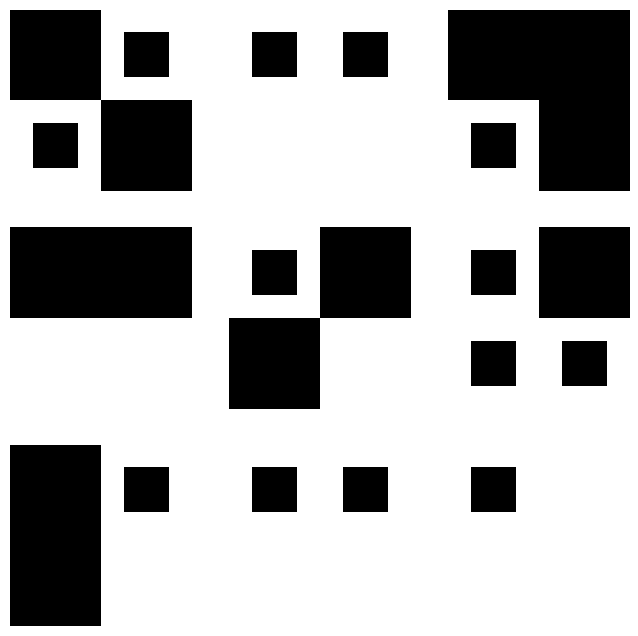

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = FigureDataset(n_samples=200, device=device, image_dir=".", transform=transform)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().cpu(), cmap="gray")
plt.show()

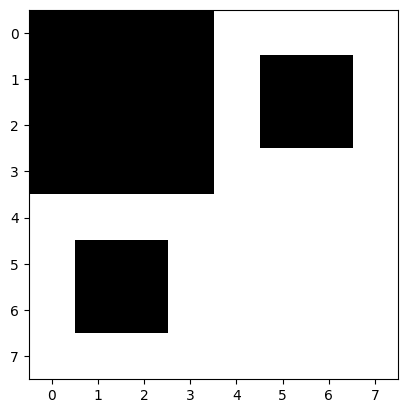

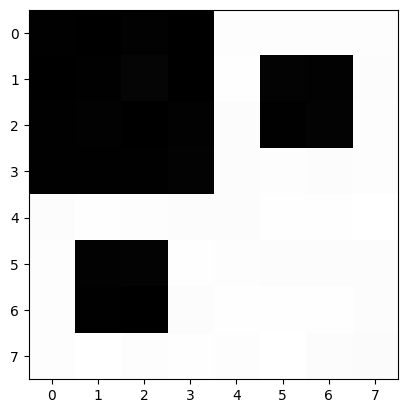

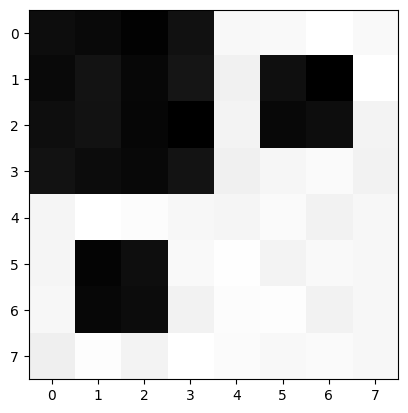

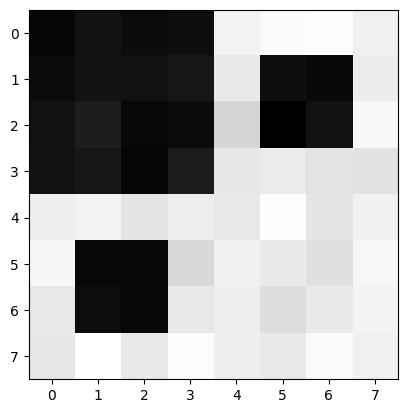

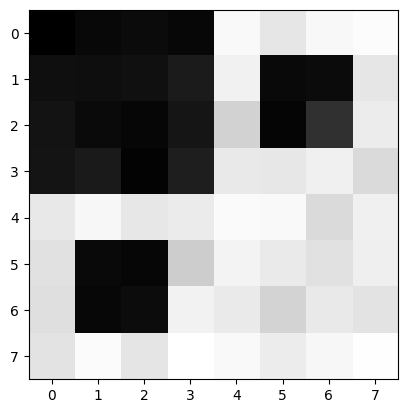

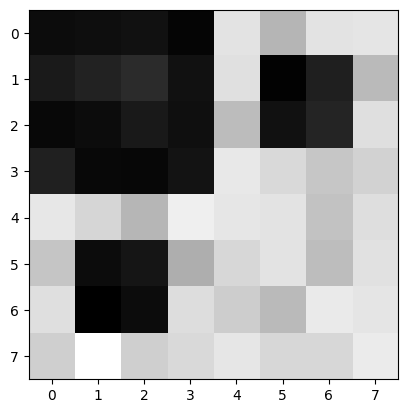

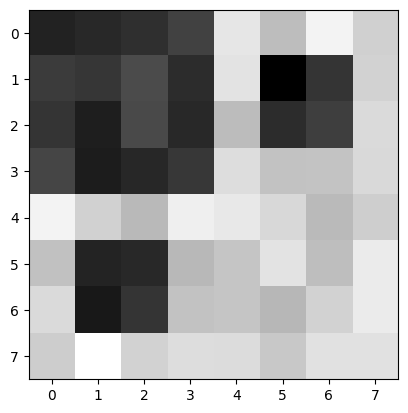

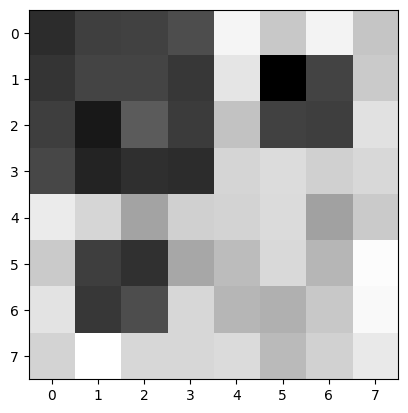

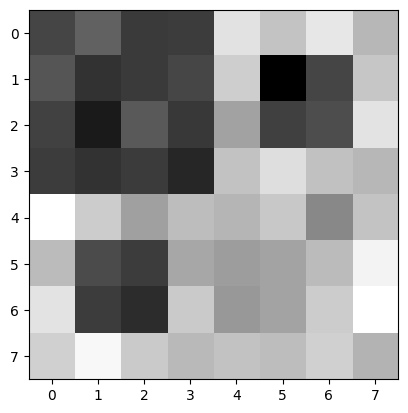

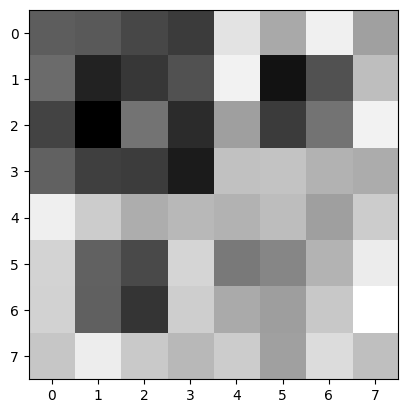

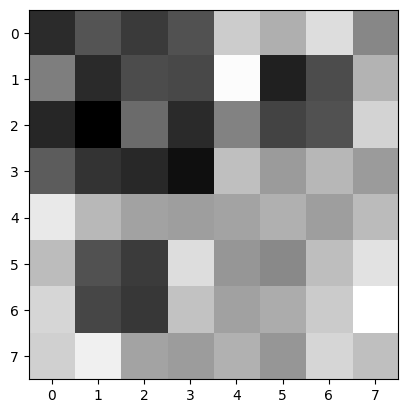

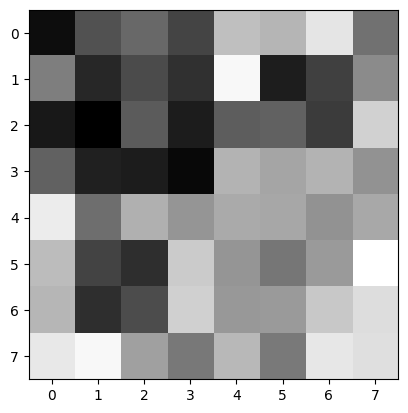

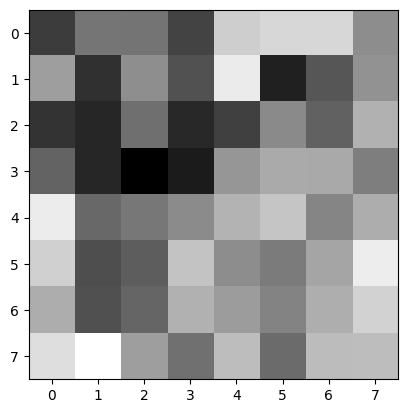

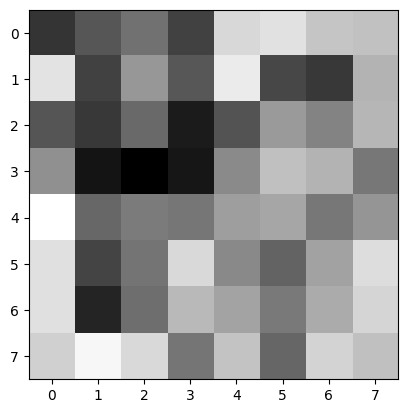

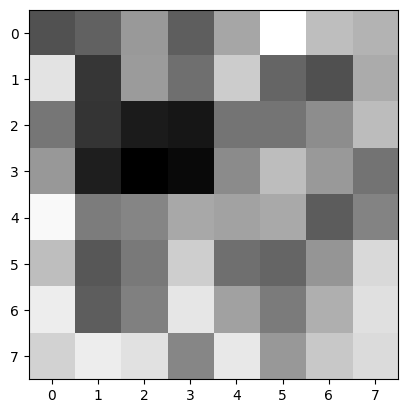

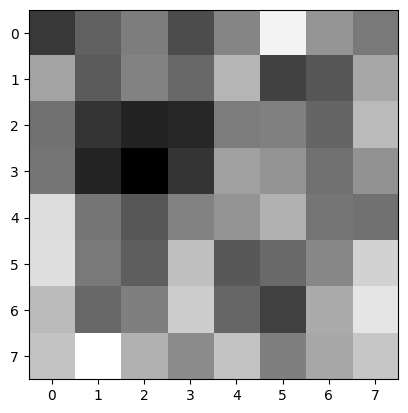

In [39]:
T = 15
model = MyMiniUNet(device=device, T=T).to(device)
diff_model = DiffusionModel(model, device=device, T=T).to(device)
img = dataset[0]
img = img.unsqueeze(0)
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.show()
for t in range(T):
  img = diff_model.forward_diffusion(img, t)[0]
  plt.imshow(img.squeeze().cpu(), cmap='gray')
  plt.show()

In [40]:
# prompt: Train the diffusion model above using the given MLP
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

T = diff_model.T
num_epochs = 10 * T

model.train()
losses = [[] for _ in range(T)]
for epoch in tqdm(range(num_epochs)):
  epoch_losses = [0 for _ in range(T)]
  for i, x in enumerate(train_loader):
    x = x.to(device)
    xts = [x]
    for t in range(T):
      xt, _ = diff_model.forward_diffusion(x, t)
      xts.append(xt)

    for t in range(T - 1, 0, -1):
      pred_noise = model(xT=xts[-1], x=xts[t], t=t)
      loss = nn.functional.mse_loss(xts[t-1], xts[t] - pred_noise)
      # print("Noise")
      # print(noises[t][0])
      # print("Pred noise")
      # print(pred_noise[t][0])
      epoch_losses[t] += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  for t in range(T):
    losses[t].append(epoch_losses[t])

100%|██████████| 150/150 [04:53<00:00,  1.95s/it]


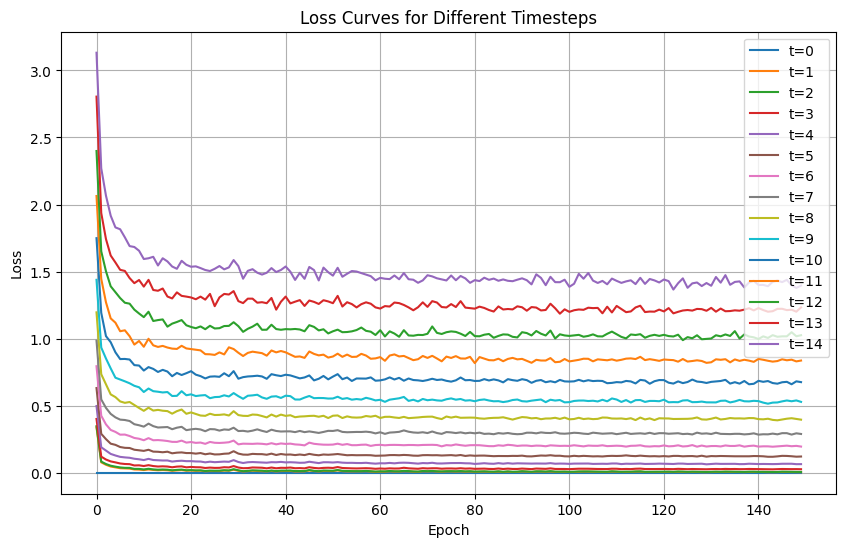

In [41]:
# prompt: Plot the loss curves generated above

# Plot the loss curves
plt.figure(figsize=(10, 6))
for t in range(T):
  plt.plot(losses[t], label=f't={t}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Timesteps')
plt.legend()
plt.grid(True)
plt.show()


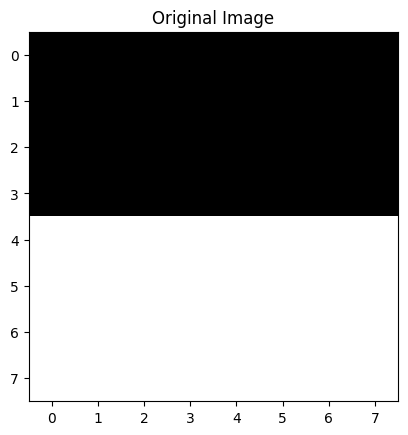

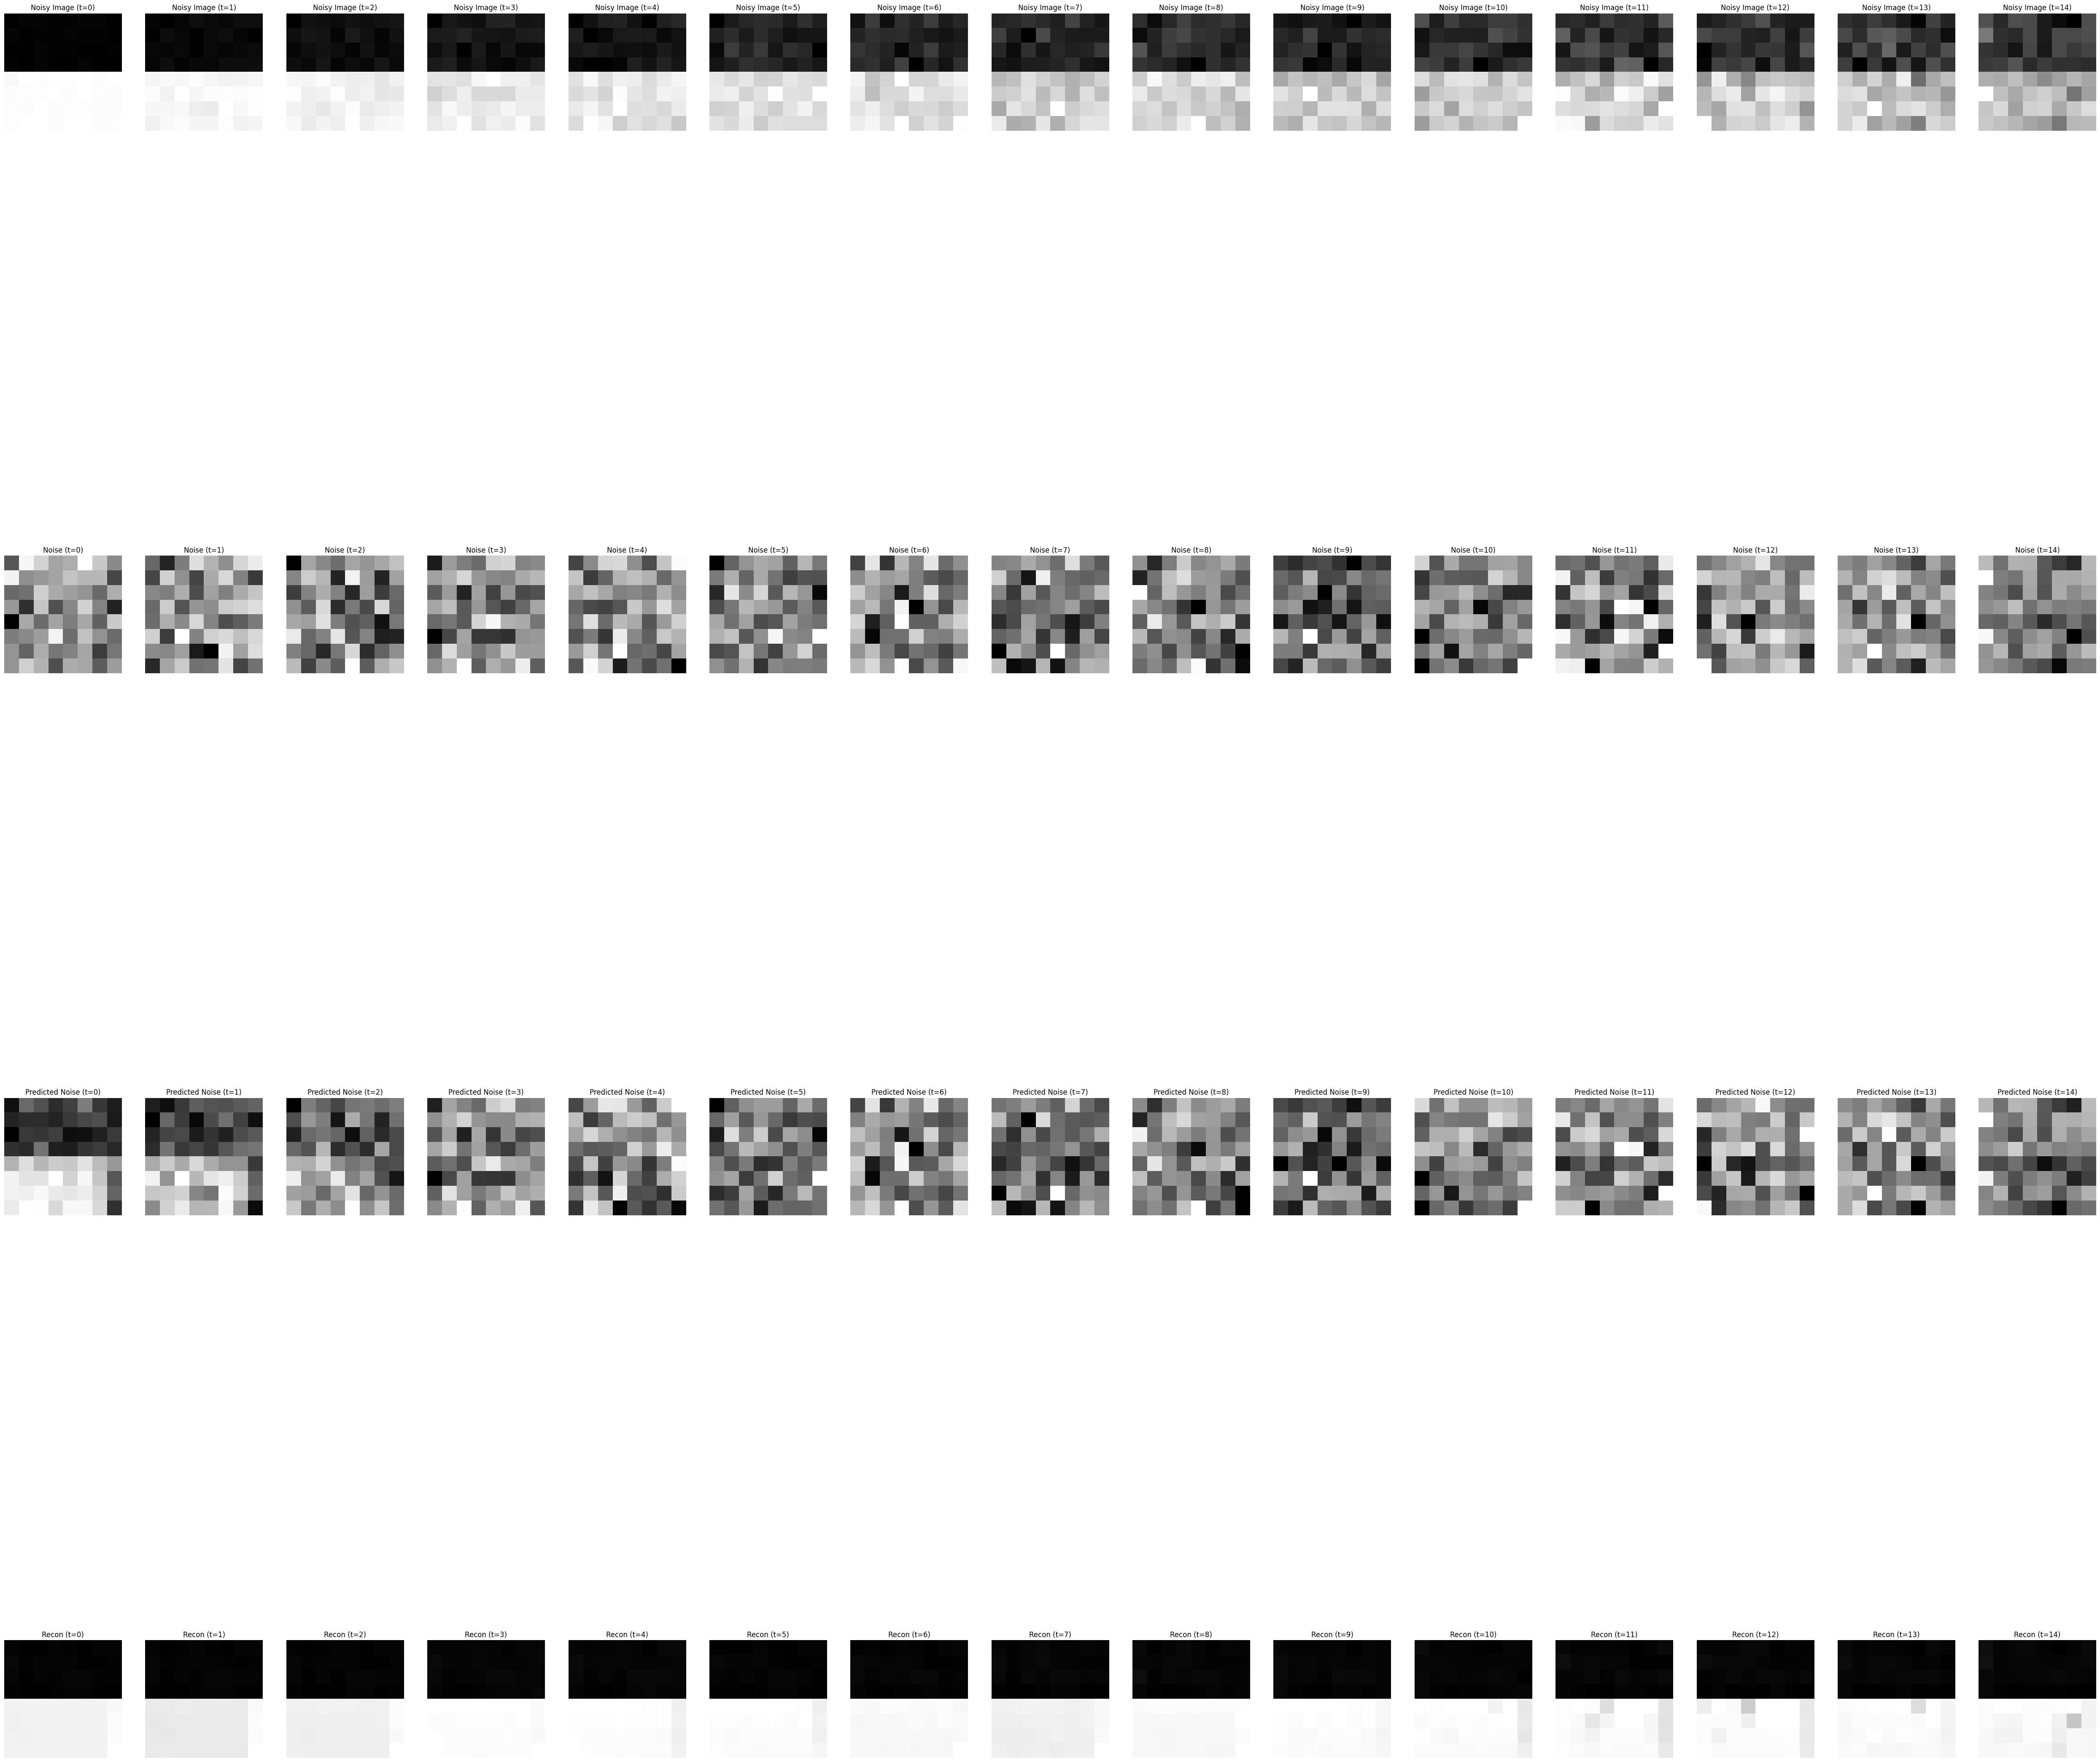

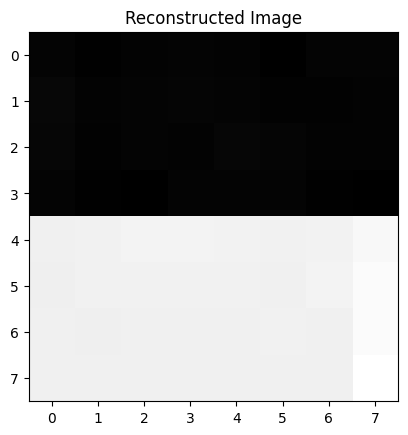

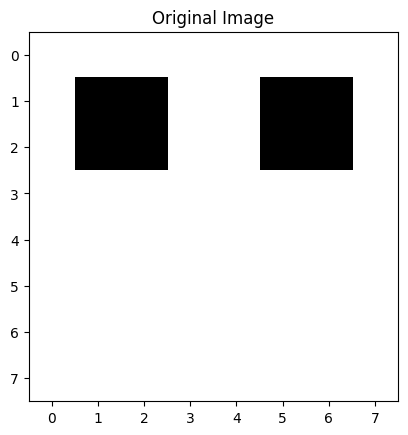

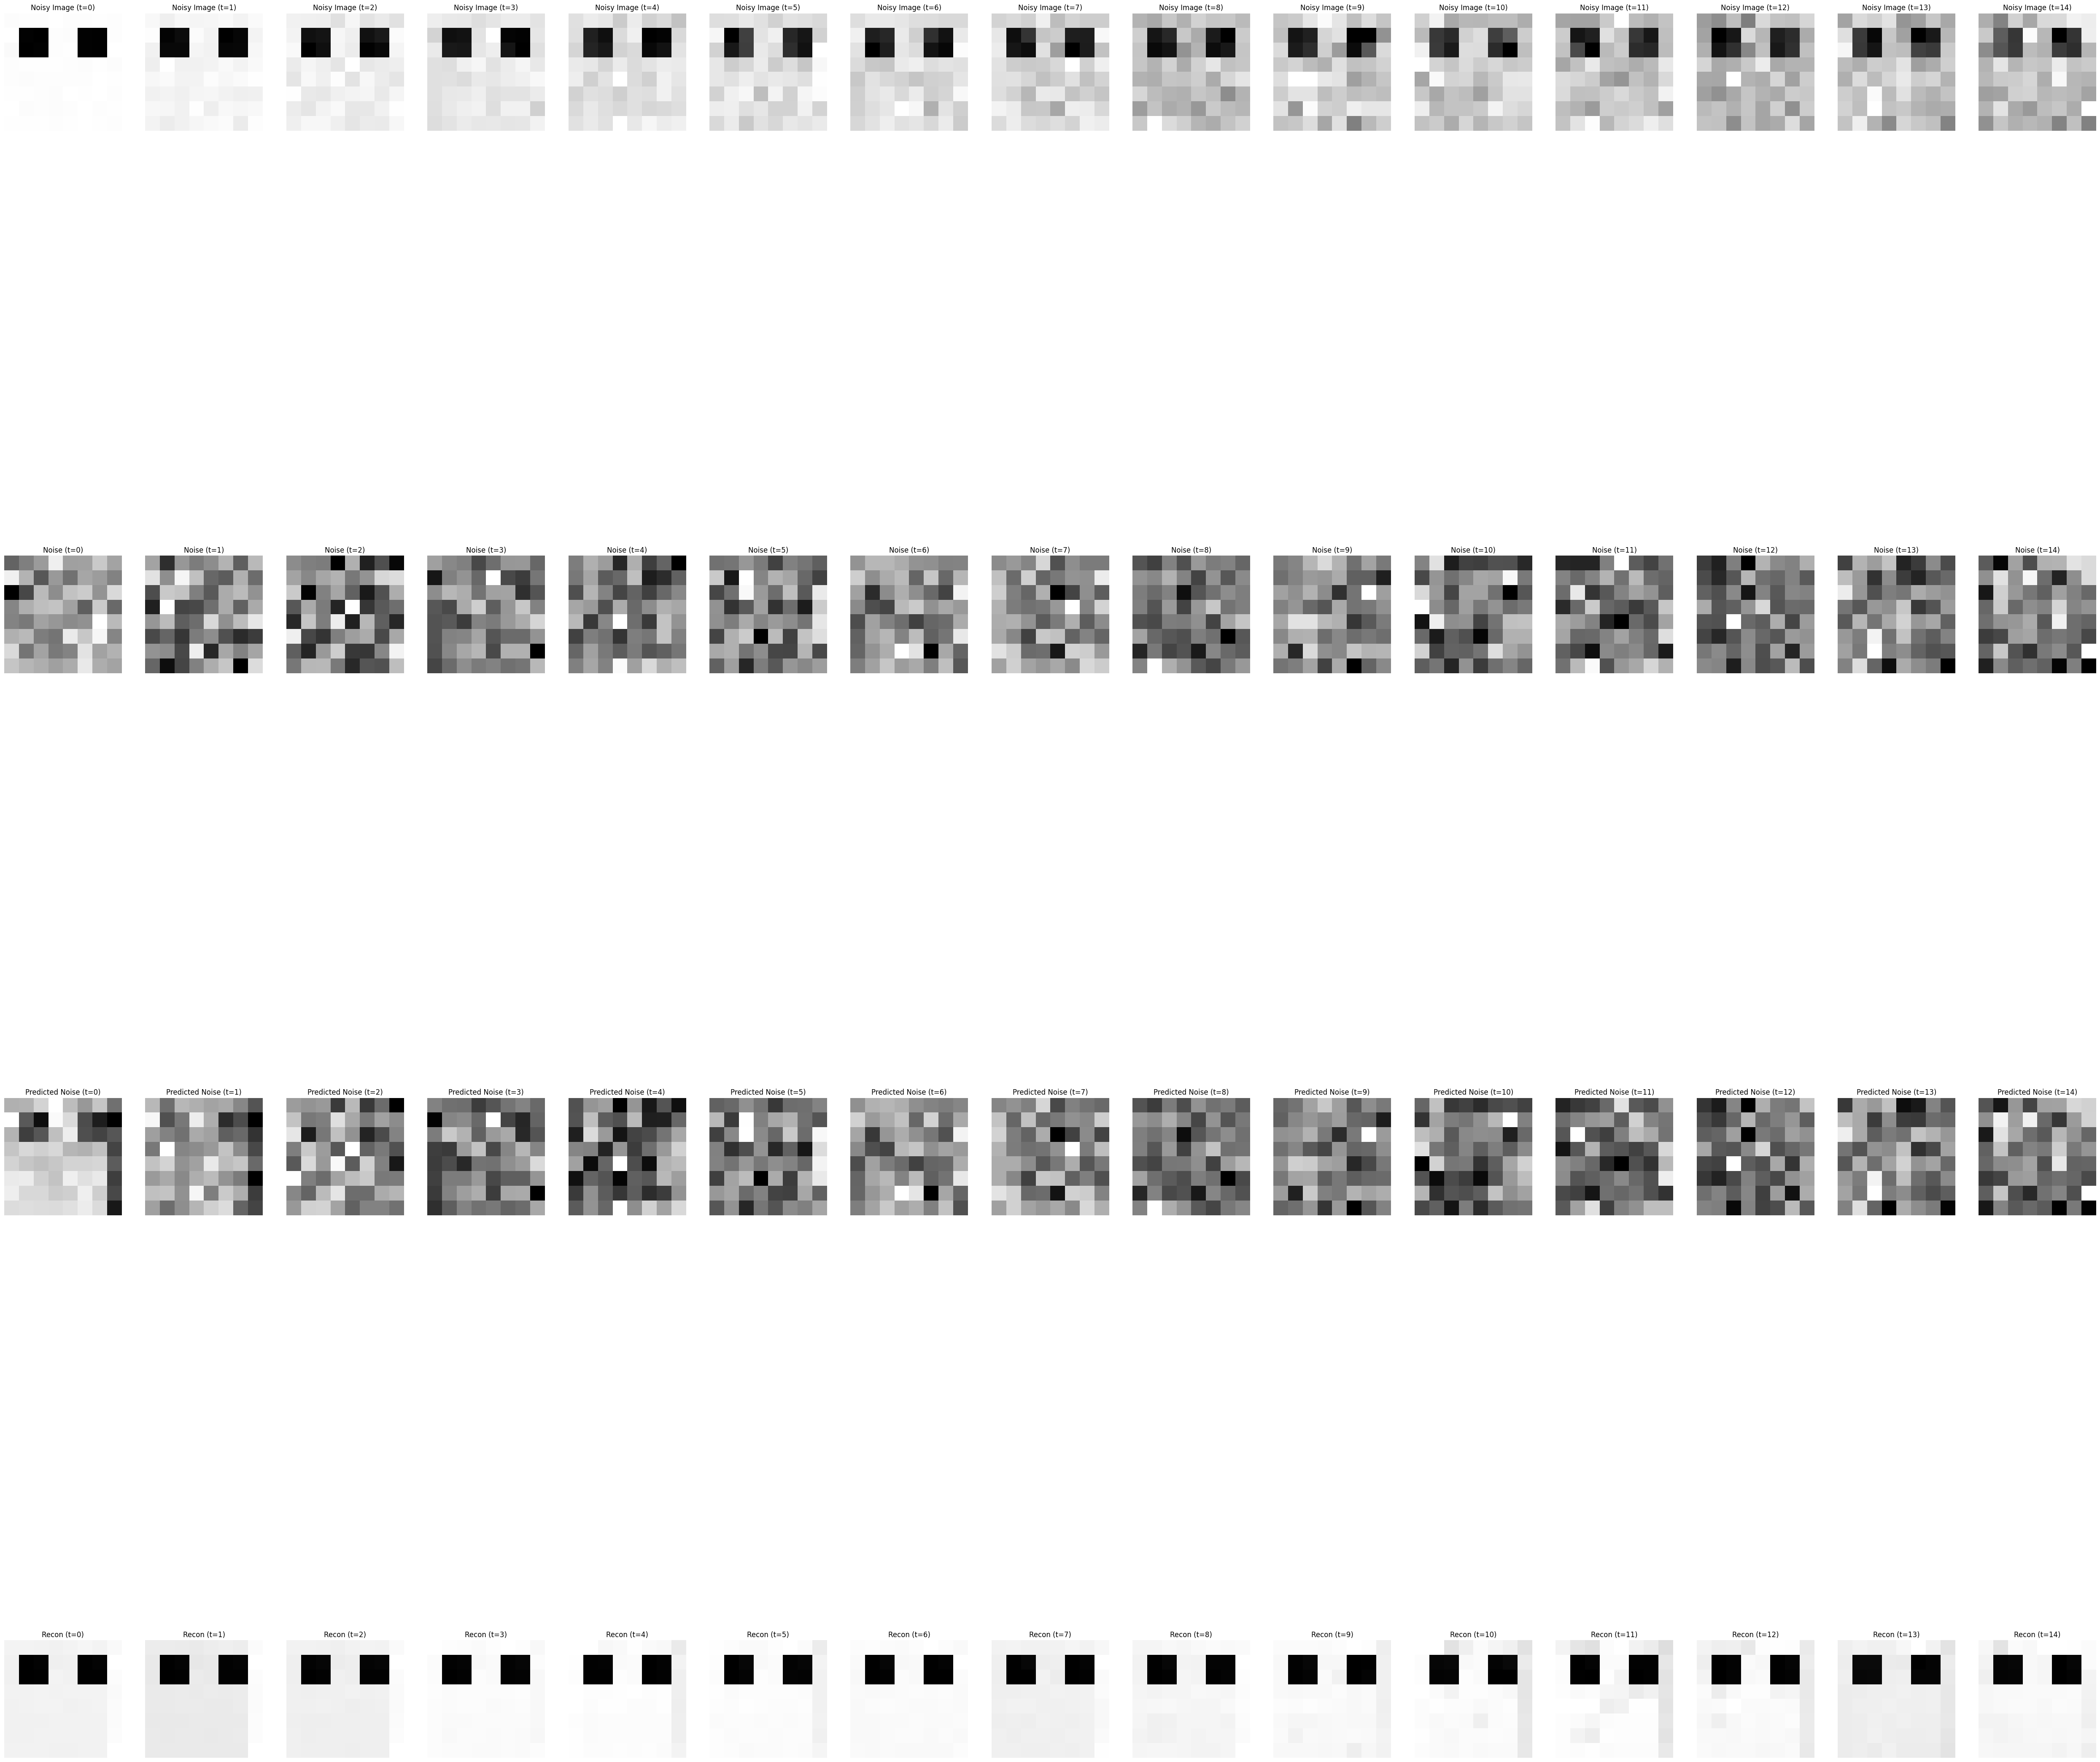

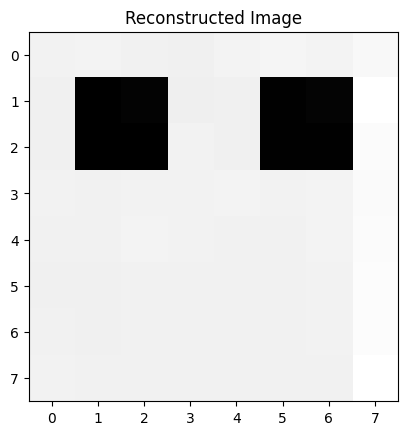

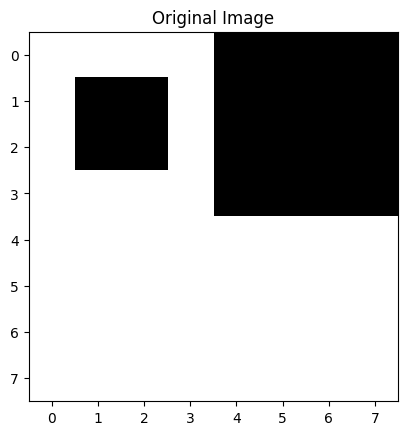

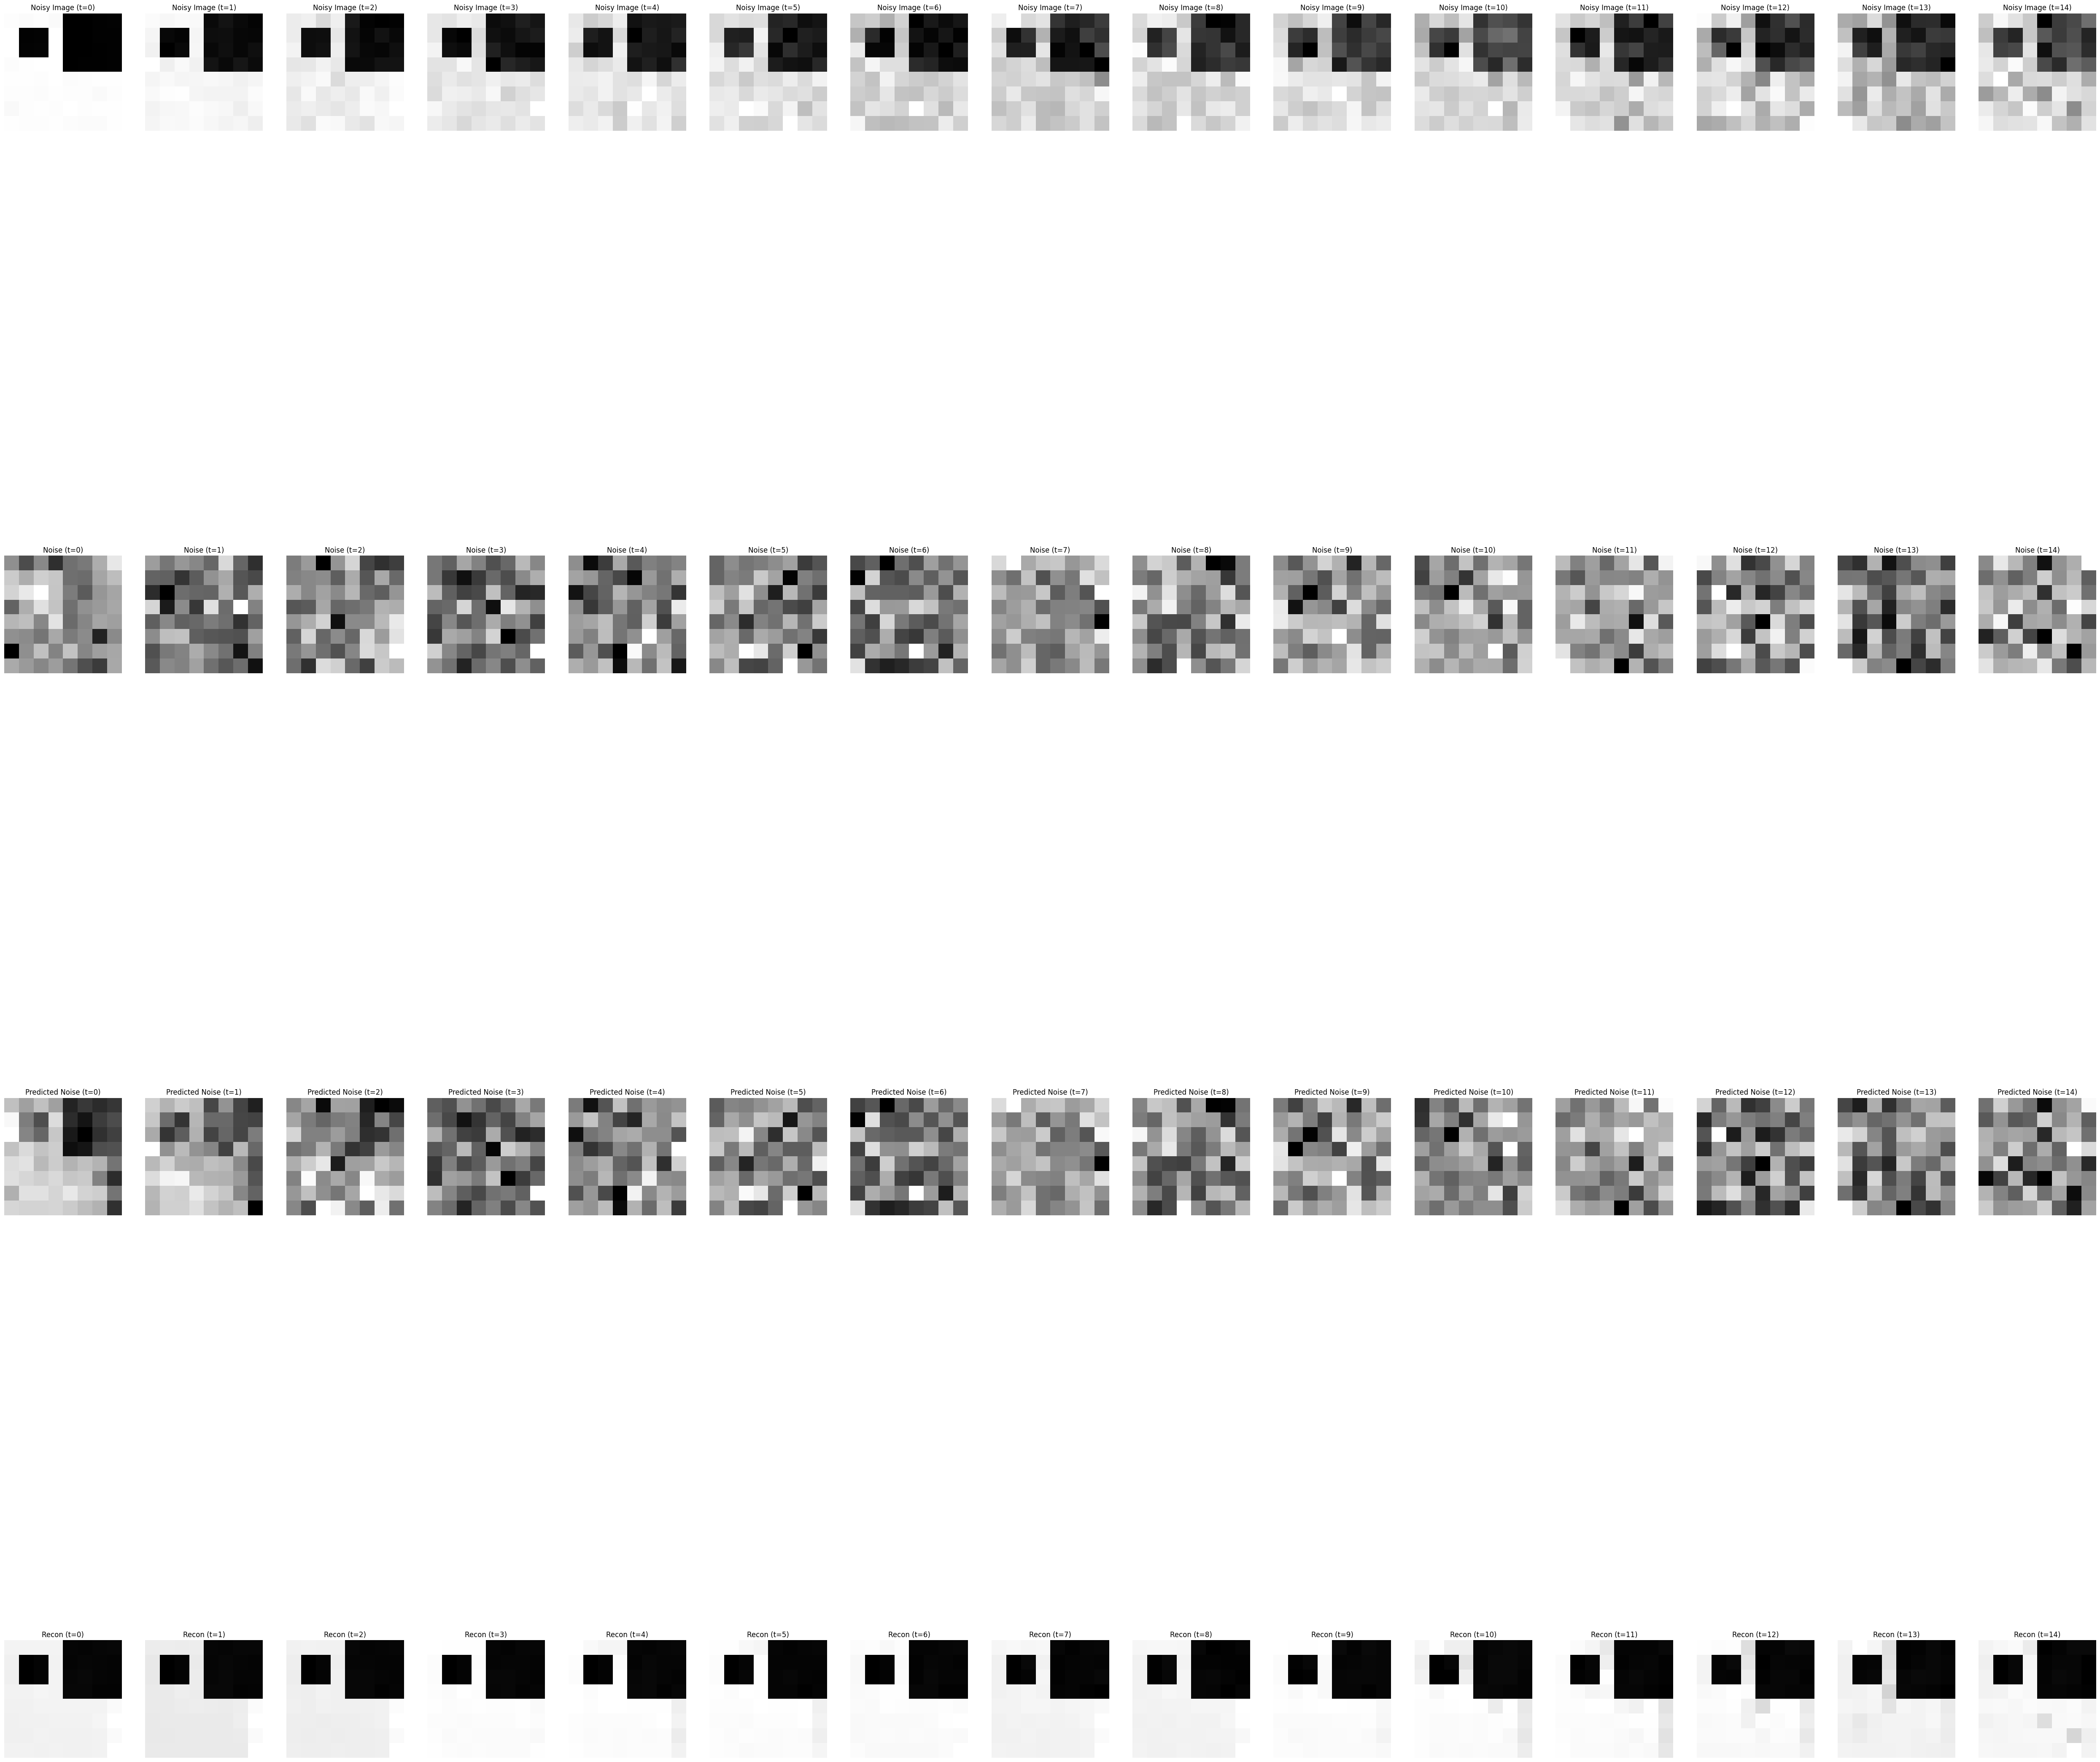

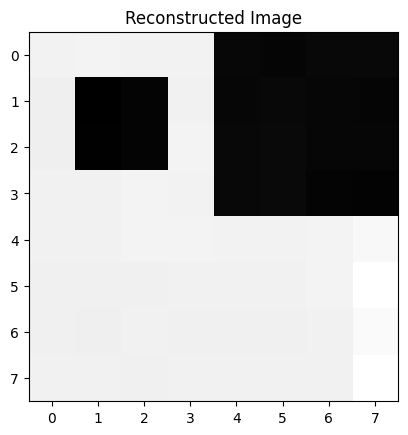

In [42]:
# prompt: For a few images of training dataset, plot the original image, plot the noisy version for t in range(T), plot the predicted noise for each of them, and also plot the predicted reconstruction

# Select a few images from the training dataset
num_images_to_plot = 3
sample_indices = torch.randint(len(dataset), size=(num_images_to_plot,))

model.eval()
with torch.no_grad():
  for sample_idx in sample_indices:
      img = dataset[sample_idx].unsqueeze(0).to(device)

      # Plot the original image
      plt.figure()
      plt.imshow(img.squeeze().cpu(), cmap='gray')
      plt.title("Original Image")
      plt.show()

      # Forward diffusion and plot noisy versions
      noisy_images = []
      noises = []
      figure = plt.figure(figsize=(64, 64))
      for t in range(T):
          noisy_img, noise = diff_model.forward_diffusion(img, t)
          noisy_images.append(noisy_img)
          noises.append(noise)
          figure.add_subplot(4, T, t + 1)
          plt.axis("off")
          plt.imshow(img.squeeze().cpu(), cmap="gray")
          plt.imshow(noisy_img.squeeze().cpu(), cmap='gray')
          plt.title(f"Noisy Image (t={t})")
          figure.add_subplot(4, T, T + t + 1)
          plt.axis("off")
          plt.imshow(img.squeeze().cpu(), cmap="gray")
          plt.imshow(noise.squeeze().cpu(), cmap='gray')
          plt.title(f"Noise (t={t})")

      # Predict noise and plot
      predicted_noises = []
      for t in range(T - 1, -1, -1):
          predicted_noise = model(xT=noisy_images[-1], x=noisy_images[t], t=t)
          predicted_noises.append(predicted_noise)
          figure.add_subplot(4, T, 2 * T + t + 1)
          plt.axis("off")
          plt.imshow(predicted_noise.squeeze().cpu(), cmap='gray')
          plt.title(f"Predicted Noise (t={t})")
          figure.add_subplot(4, T, 3 * T + t + 1)
          plt.axis("off")
          plt.imshow((noisy_images[t] - predicted_noise).squeeze().cpu(), cmap='gray')
          plt.title(f"Recon (t={t})")
      plt.show()

      # Reverse process and plot reconstruction
      reconstructed_img = noisy_images[-1]
      for t in reversed(range(T)):
          reconstructed_img = diff_model.reverse_process(xT=noisy_images[-1], xt=reconstructed_img, t=t)
      plt.imshow(reconstructed_img.squeeze().cpu(), cmap='gray')
      plt.title("Reconstructed Image")
      plt.show()


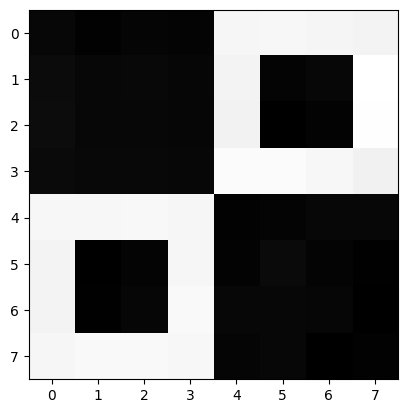

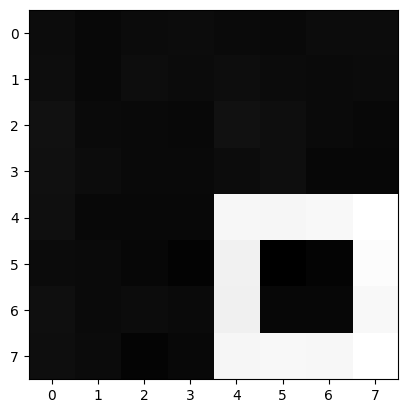

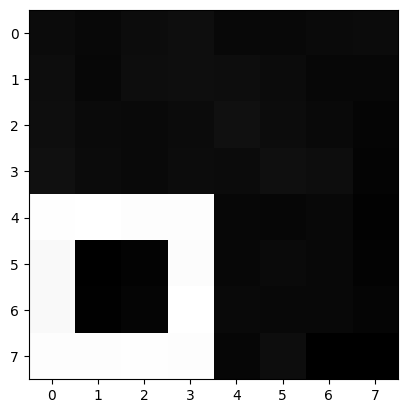

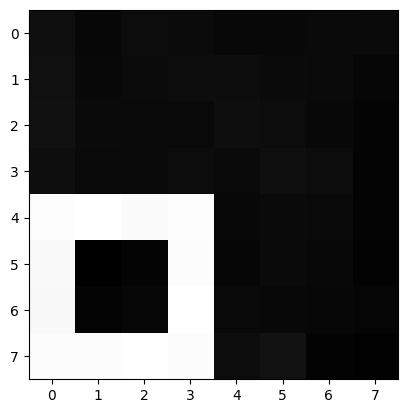

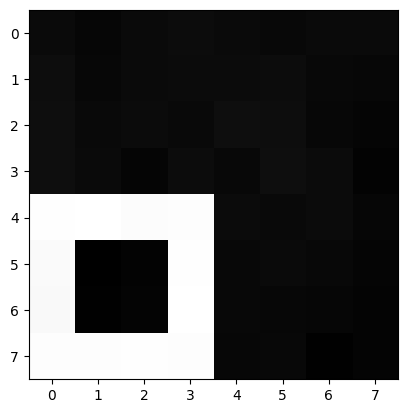

In [43]:
# prompt: Sample some images with the diffusion model that I trained above

# Sample images
model.eval()
with torch.no_grad():
  for _ in range(5):  # Generate 5 samples
    sample = diff_model.sample((1, 1, 8, 8))
    plt.imshow(sample.squeeze().cpu(), cmap='gray')
    plt.show()
